In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from scipy.integrate import odeint, solve_ivp
from scipy.ndimage.filters import laplace
from scipy.special import erf
from scipy.optimize import curve_fit
from math import sqrt

In [26]:
def dydt(t, y, alpha, r_d, var):
    dalpha = alpha[1]-alpha[0]
    rho = np.trapz(y, dx=dalpha)
    dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy[0] = alpha[0] * y[0] + alpha[0] * var * (y[1] - y[0]) / dalpha**2
    dy[-1] = alpha[-1] * y[-1] + alpha[-1] * var * (y[-2] - y[-1]) / dalpha**2
    dy *= 1 - rho
    dy -= r_d * y
    return dy


def dydt_nove(t, y, alpha, r_d, var):  # without volume restriction as in experiment
    dalpha = alpha[1]-alpha[0]
    # rho = np.trapz(y, dx=dalpha)
    dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy[0] = alpha[0] * y[0] + alpha[0] * var * (y[1] - y[0]) / dalpha**2
    dy[-1] = alpha[-1] * y[-1] + alpha[-1] * var * (y[-2] - y[-1]) / dalpha**2
    # dy *= 1 - rho
    dy -= r_d * y
    return dy

def dydt_constantpop(t, y, alpha, var):  # only mutation effect
    dalpha = alpha[1]-alpha[0]
    rho = np.trapz(y, dx=dalpha)
    meanalpha = np.trapz(alpha * y, dx=dalpha) / rho
    dy = alpha * y + var * np.gradient(y, dalpha) + 0.5 * alpha * var * laplace(y) / dalpha**2
    dy[0] = alpha[0] * y[0] + alpha[0] * var * (y[1] - y[0]) / dalpha**2
    dy[-1] = alpha[-1] * y[-1] + alpha[-1] * var * (y[-2] - y[-1]) / dalpha**2
    # dy *= 1 - rho
    dy -= meanalpha * y
    return dy


In [27]:
def exp_procedure(y0, growth, t_growth=1, reps=1000, nrecord=100, args=None):
    """Simulate exponential cell culture growth with intermittent dilutions to initial cell density.
    """
    y = np.zeros((reps//nrecord+1,) + y0.shape)
    y[0] = y0
    n0 = np.trapz(y0, dx=dalpha, axis=-1)
    for i in range(reps):
        # print(solve_ivp(growth, (0, t_growth), y0, method='LSODA', t_eval=np.array([t_growth]), args=args).y.shape)
        y0 = solve_ivp(growth, (0, t_growth), y0, t_eval=np.array([0, t_growth]), args=args).y[..., -1]
        y0 *= n0 / np.trapz(y0, dx=dalpha, axis=-1)
        
        if i % nrecord == 0:
            y[i//nrecord+1] = y0
        
    return y

In [36]:
# notes: use e.coli experiment (parametrized!)
# how to model the loss of diversity 

r_b = 10 * np.log(2)
a_max = 2 * r_b  # to be fitted
alpha, dalpha = np.linspace(0, a_max, num=201, retstep=True)
r_d = 0
K = 6e4  # effective population size - does that make sense?
n0 = 8e3  # bottleneck size - ---------"---------?
var = 1e-6 * (1e-2 * r_b) **2  # to be fitted
tmax = 100
dens0 = K
y0 = np.zeros_like(alpha)
y0[len(alpha)//2] = dens0 / dalpha
# y0[0] = dens0 / dalpha
print(r_b, alpha[len(alpha)//2], np.trapz(y0, dx=dalpha, axis=-1), np.trapz(alpha * y0, dx=dalpha, axis=-1) / np.trapz(y0, dx=dalpha, axis=-1))

6.931471805599453 6.931471805599452 60000.0 6.931471805599451


In [37]:
y = exp_procedure(y0, dydt_nove, args=(alpha, r_d, var), reps=1000, nrecord=10)
y2 = solve_ivp(dydt_constantpop, (0, tmax), y0, t_eval=np.linspace(0, tmax, y.shape[0]), args=(alpha, var)).y.T

In [38]:
ncells1 = np.trapz(y, dx=dalpha, axis=-1)
ncells2 = np.trapz(y2, dx=dalpha, axis=-1)

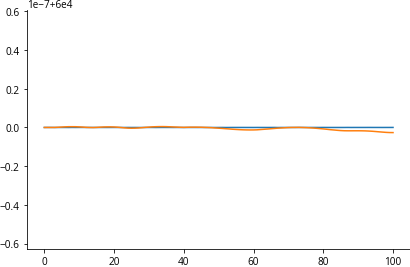

In [39]:
plt.plot(ncells1)
plt.plot(ncells2)

In [40]:
meanalpha1 = np.trapz(alpha * y, dx=dalpha, axis=-1) / ncells1
meanalpha2 = np.trapz(alpha * y2, dx=dalpha, axis=-1) / ncells2

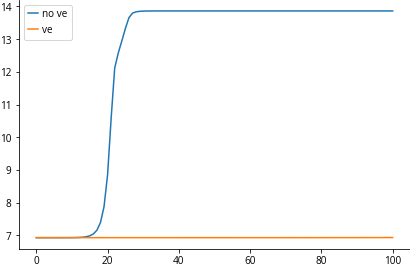

In [41]:
plt.plot(meanalpha1, label='no ve')
plt.plot(meanalpha2, label='ve')
plt.legend()

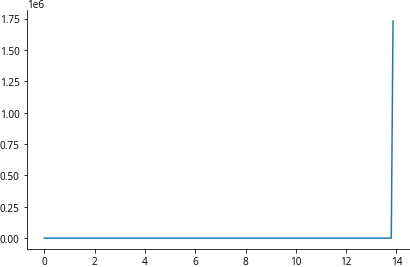

In [42]:
plt.plot(alpha, y[-1])